<center><h1> Predicting Length of Stay for Patients </h1></center>

In [1]:
import pandas as pd #To read the csv file and manage dataframes  
import numpy as np
import warnings #To hide the warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import seaborn as sns #To create visualizations
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

### Importing Dataset

In [2]:
data= pd.read_csv('HealthCareDataSet.csv')

In [3]:
data.head()

,Id,LengthOfStay,ReadmissionCount,Gender,FacilityId,KidneyAilments,HeartAilments,PyschologicalAilments,SubstanceAbuseHistory,BMI,ABG,Pulse,SecondaryDiagnosis
0,13564856414,5,2.0,F,1338,NaN,NaN,False,No,32.7,152.0,64.0,2.0
1,13564856415,3,1.0,F,4964,NaN,NaN,True,No,31.1,165.0,105.0,1.0
2,13564856416,6,NaN,M,7593,NaN,NaN,False,No,32.4,111.0,53.0,NaN
3,13564856417,5,NaN,M,1739,NaN,NaN,False,No,31.2,175.0,44.0,3.0
4,13564856418,5,NaN,M,1703,NaN,NaN,False,Yes,31.9,114.0,93.0,4.0


### Data Cleaning

In [4]:
data.isnull().sum() # Looking for null values

Id                           0
LengthOfStay                 0
ReadmissionCount          5570
Gender                       0
FacilityId                   0
KidneyAilments           10999
HeartAilments            10999
PyschologicalAilments        0
SubstanceAbuseHistory      392
BMI                          2
ABG                          0
Pulse                        2
SecondaryDiagnosis         239
dtype: int64

In [5]:
data.shape

(10999, 13)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     10999 non-null  int64  
 1   LengthOfStay           10999 non-null  int64  
 2   ReadmissionCount       5429 non-null   float64
 3   Gender                 10999 non-null  object 
 4   FacilityId             10999 non-null  int64  
 5   KidneyAilments         0 non-null      float64
 6   HeartAilments          0 non-null      float64
 7   PyschologicalAilments  10999 non-null  bool   
 8   SubstanceAbuseHistory  10607 non-null  object 
 9   BMI                    10997 non-null  float64
 10  ABG                    10999 non-null  float64
 11  Pulse                  10997 non-null  float64
 12  SecondaryDiagnosis     10760 non-null  float64
dtypes: bool(1), float64(7), int64(3), object(2)
memory usage: 1.0+ MB


Dropping KidneyAilments and HeartAilments since they both have null values.

In [7]:
data.drop(['KidneyAilments','HeartAilments'],axis=1,inplace=True)

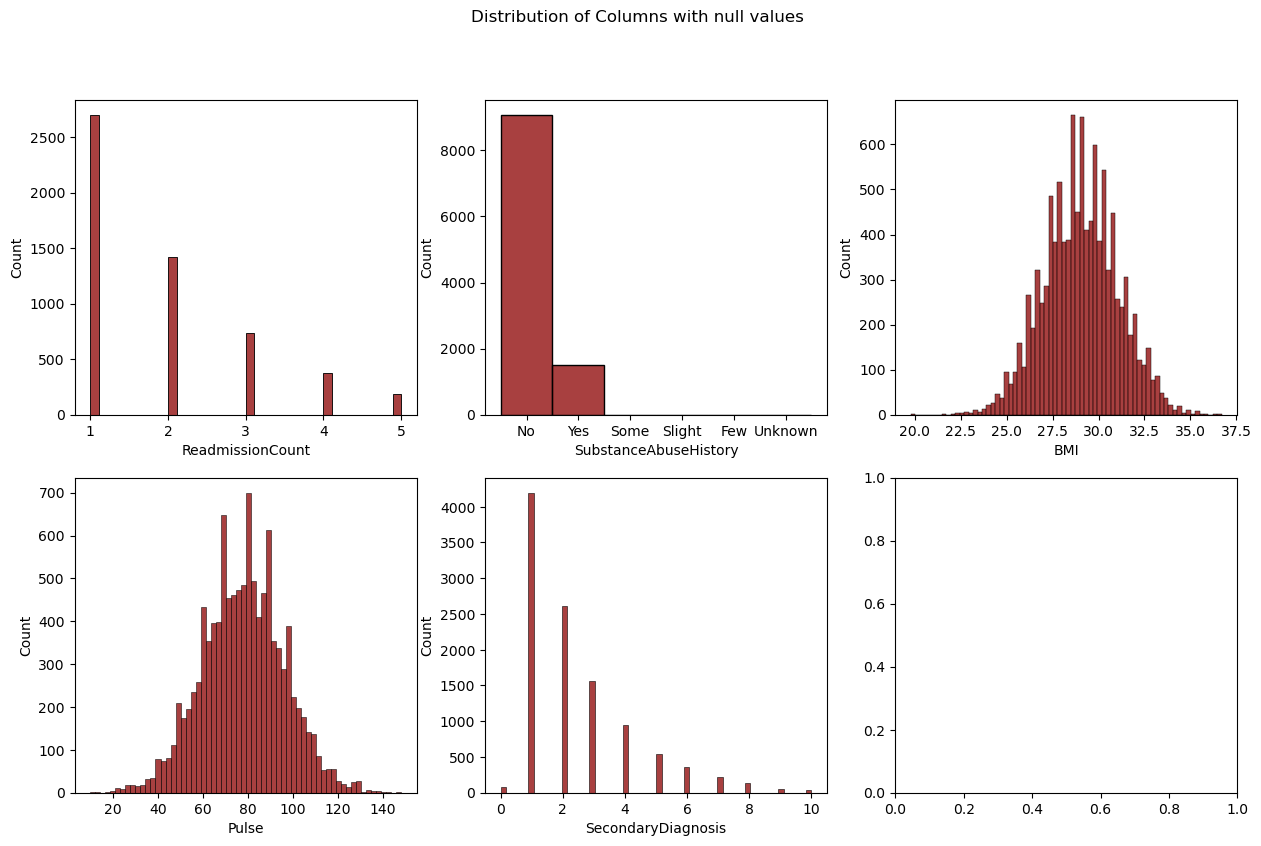

In [8]:
null_values = ['ReadmissionCount','SubstanceAbuseHistory','BMI','Pulse','SecondaryDiagnosis']
fig,axs = plt.subplots(2,3,figsize=(15,9))
i = 1
j = 1
fig.suptitle("Distribution of Columns with null values")
for col in null_values:
    sns.histplot(data[col],ax=axs[i-1][j-1],color='darkred')
    if (j %3 == 0): i+=1
    if j!=3: j=(j+1)
    else: j = 1
plt.show()

As we can see, ReadmissionCount,SecondaryDiagnosis and SubstanceAbuseHistory are categorical values with the first two being ordinal type.
Meanwhile, Pulse and BMI are numerical values.

In [9]:
data.ReadmissionCount = data.ReadmissionCount.astype('object')
data.SecondaryDiagnosis = data.SecondaryDiagnosis.astype('object')
data.SubstanceAbuseHistory = data.SubstanceAbuseHistory.astype('object')
data.PyschologicalAilments = data.PyschologicalAilments.astype('object')

Looking at null values in ReadmissionCount

In [10]:
data.ReadmissionCount.value_counts()

ReadmissionCount
1.0    2701
2.0    1422
3.0     736
4.0     380
5.0     190
Name: count, dtype: int64

In [11]:
data.ReadmissionCount.describe()

count     5429.0
unique       5.0
top          1.0
freq      2701.0
Name: ReadmissionCount, dtype: float64

In [12]:
data['ReadmissionCount'].fillna(data.ReadmissionCount.mode().values[0],inplace=True)

Looking at null values in SecondaryDiagnosis

In [13]:
data.SecondaryDiagnosis.value_counts()

SecondaryDiagnosis
1.0     4196
2.0     2610
3.0     1568
4.0      946
5.0      545
6.0      363
7.0      221
8.0      133
0.0       81
9.0       59
10.0      38
Name: count, dtype: int64

In [14]:
data.SecondaryDiagnosis.describe()

count     10760.0
unique       11.0
top           1.0
freq       4196.0
Name: SecondaryDiagnosis, dtype: float64

In [15]:
data['SecondaryDiagnosis'].fillna(data.SecondaryDiagnosis.mode().values[0],inplace=True)

In [16]:
data.SubstanceAbuseHistory.value_counts()

SubstanceAbuseHistory
No         9080
Yes        1517
Some          3
Slight        3
Few           3
Unknown       1
Name: count, dtype: int64

In [17]:
data.SubstanceAbuseHistory.describe()

count     10607
unique        6
top          No
freq       9080
Name: SubstanceAbuseHistory, dtype: object

In [18]:
data.SubstanceAbuseHistory.fillna(data.SubstanceAbuseHistory.mode().values[0],inplace=True)

Looking at the null values of numercial columns

In [19]:
(data.BMI.isnull().sum()/data.shape[0])*100

0.018183471224656786

In [20]:
(data.Pulse.isnull().sum()/data.shape[0])*100

0.018183471224656786

The contribution of null values of BMI and Pulse are less than 0.5%. So we will drop them entirely.

In [21]:
data.dropna(subset = ['BMI','Pulse'],axis=0,inplace=True)

In [22]:
data.isnull().sum()

Id                       0
LengthOfStay             0
ReadmissionCount         0
Gender                   0
FacilityId               0
PyschologicalAilments    0
SubstanceAbuseHistory    0
BMI                      0
ABG                      0
Pulse                    0
SecondaryDiagnosis       0
dtype: int64

Hence, all the null values have been removed. 

Dropping Id and FacilityId since they are both primary keys.

In [23]:
data.drop(['Id','FacilityId'],axis=1,inplace=True)

### Exploratory Data Analysis and Data Pre-processing

In [24]:
data.ReadmissionCount = data.ReadmissionCount.astype('object')
data.SecondaryDiagnosis = data.SecondaryDiagnosis.astype('object')
data.SubstanceAbuseHistory = data.SubstanceAbuseHistory.astype('object')
data.PyschologicalAilments = data.PyschologicalAilments.astype('object')

In [25]:
cat_columns = data.select_dtypes(include='object').columns.tolist()
num_columns = data.select_dtypes(include='number').columns.tolist()

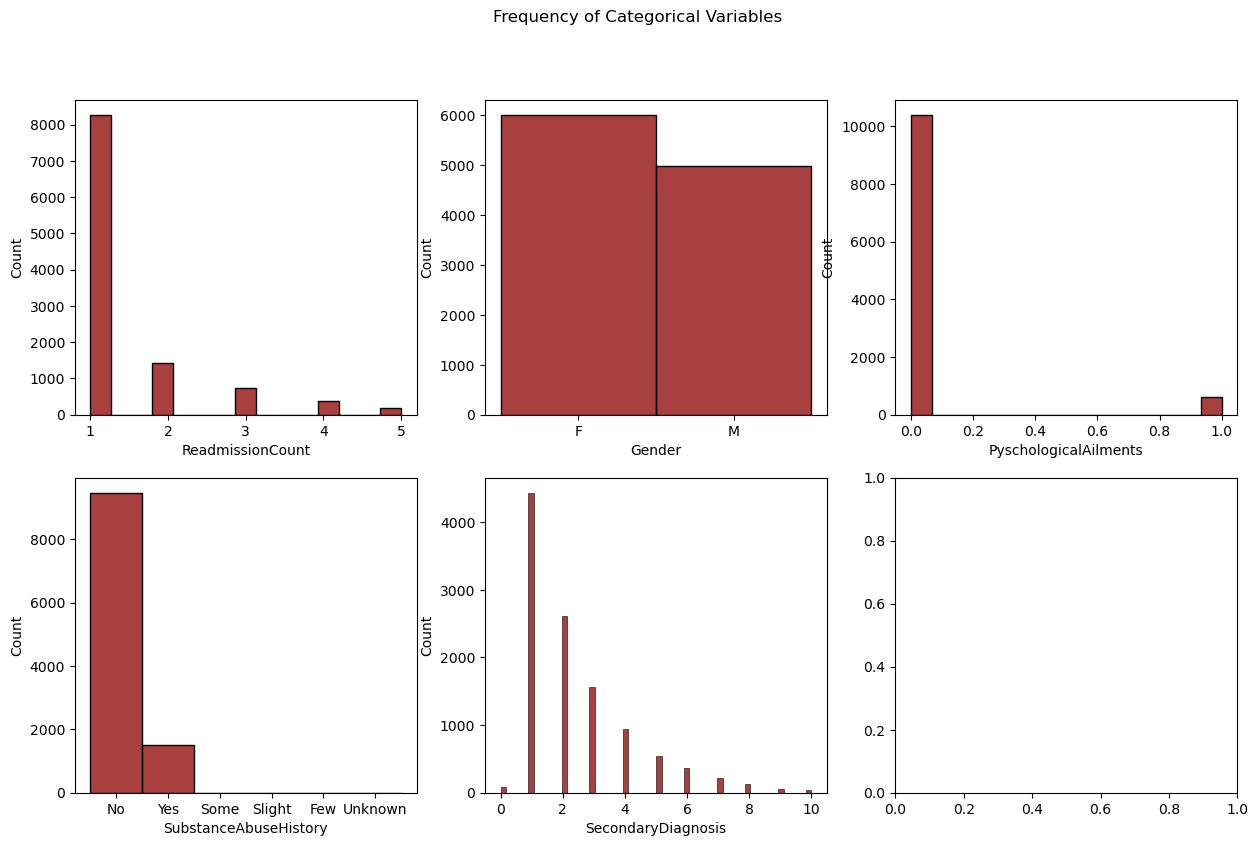

In [26]:
fig,axs = plt.subplots(2,3,figsize=(15,9))
i = 1
j = 1
fig.suptitle("Frequency of Categorical Variables")
for col in cat_columns:
    sns.histplot(data[col],ax=axs[i-1][j-1],color='darkred')
    if (j %3 == 0): i+=1
    if j!=3: j=(j+1)
    else: j = 1
plt.show()

SubstanceAbuseHistory has additional columns. 

In [27]:
data.SubstanceAbuseHistory.value_counts()

SubstanceAbuseHistory
No         9471
Yes        1516
Some          3
Slight        3
Few           3
Unknown       1
Name: count, dtype: int64

Replacing 'Some', 'Slight', 'Few', 'Unknown' 

In [28]:
data['SubstanceAbuseHistory'].replace(to_replace=['Some','Slight','Few'],value='Yes',inplace=True)

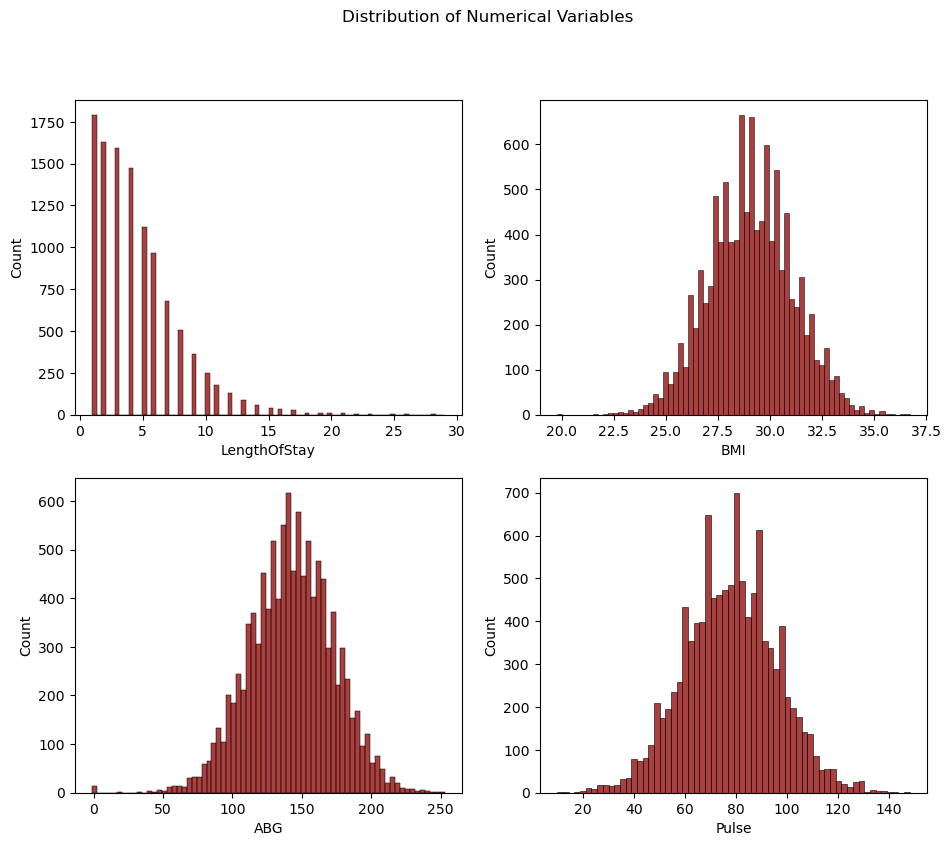

BMI      0.009490
ABG     -0.162384
Pulse    0.019440
dtype: float64

In [29]:
fig,axs = plt.subplots(2,2,figsize=(11,9))
i = 1
j = 1
fig.suptitle("Distribution of Numerical Variables")
for col in num_columns:
    sns.histplot(data[col],ax=axs[i-1][j-1],color='darkred')
    if (j %2 == 0): i+=1
    if j!=2: j=(j+1)
    else: j = 1
plt.show()
data[num_columns[1:]].skew()

Outlier Analysis

In [30]:
outlier_cols = ['BMI','ABG','Pulse']

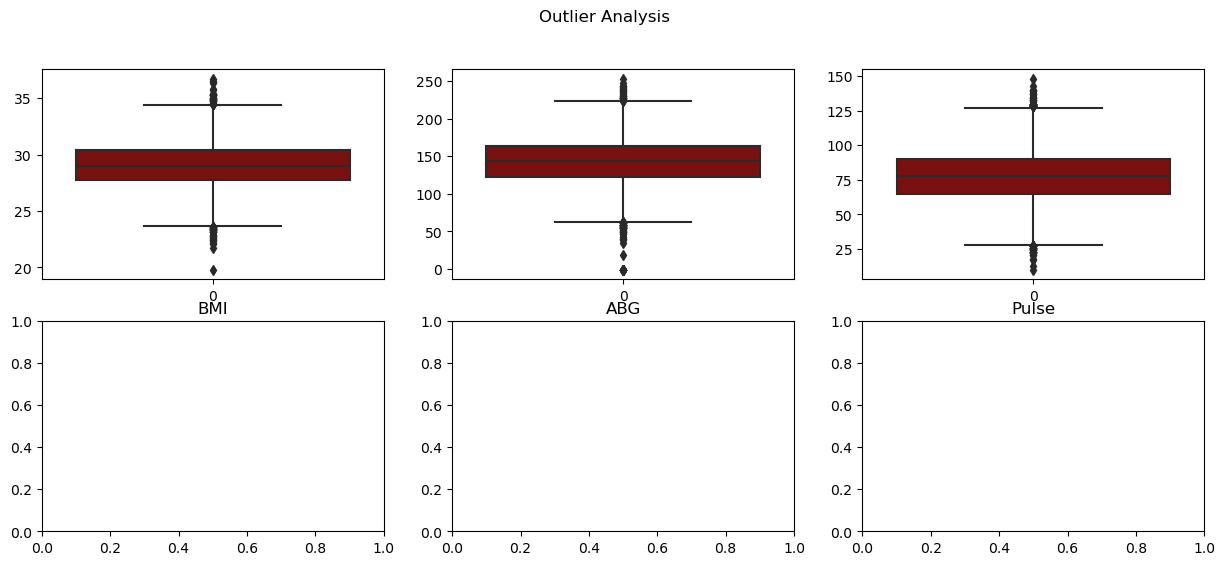

In [31]:
fig,axs = plt.subplots(2,3,figsize=(15,6))
i = 1
j = 1
fig.suptitle("Outlier Analysis")
for col in outlier_cols:
    sns.boxplot(data[col],ax=axs[i-1][j-1],color='darkred')
    axs[1][j-1].set_title(col)
    if j!=3: j=(j+1)
    else: j = 1
plt.show()

- The first feature is our target variable so it can be ignored.
- BMI, ABG and Pulse have outliers. So we impute them with the upper/lower limit values. 

Modularize Outlier analysis into a function

In [32]:
def replace_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3-Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    col = col.apply(lambda x: upper_limit if x > upper_limit else lower_limit if x < lower_limit else x)
    return col

In [33]:
for col in outlier_cols:
    data[col] = replace_outliers(data[col])

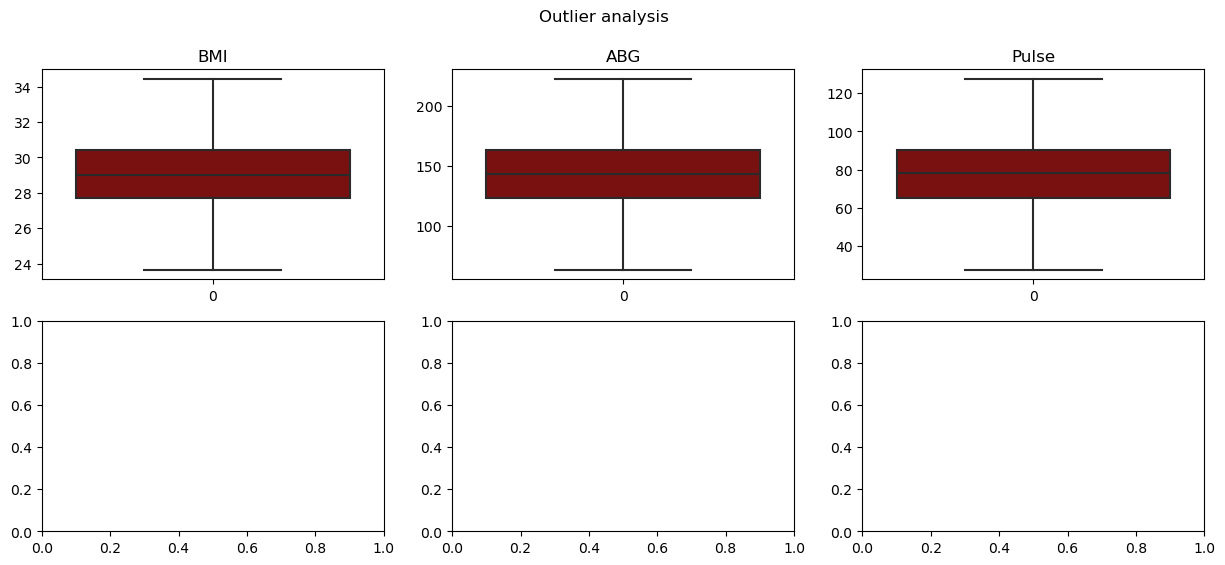

Number of BMI outliers are : 0
Number of ABG outliers are : 0
Number of Pulse outliers are : 0


In [34]:
fig,axs = plt.subplots(2,3,figsize=(15,6))
i = 1
j = 1
fig.suptitle("Outlier analysis")
for col in outlier_cols:
    sns.boxplot(data[col],ax=axs[i-1][j-1],color='darkred')
    axs[i-1][j-1].set_title(col)
    if (j %3 == 0): i+=1
    if j!=3: j=(j+1)
    else: j = 1
plt.show()


for col in outlier_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    lower_limit = Q1 - 1.5 * (Q3 - Q1)
    upper_limit = Q3 + 1.5 * (Q3 - Q1)

    print(f'Number of {col} outliers are :', data[(data[col] < lower_limit) | (data[col] > upper_limit)].shape[0])

Therefore, there are no more outliers present in the data.

### Exploratory Data Analysis

#### Univariate Analysis

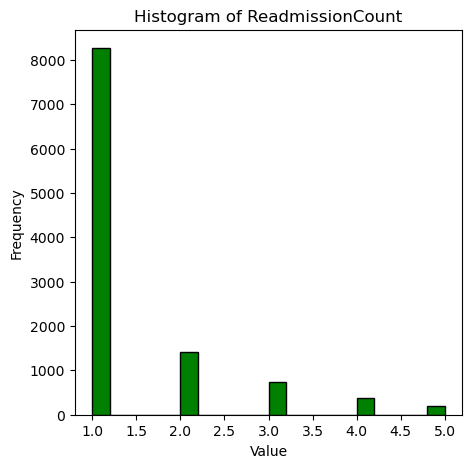

In [35]:
# Create a histogram plot for the Readmission Count
plt.figure(figsize=(5,5))
plt.hist(data['ReadmissionCount'], bins=20, color='green', edgecolor='black')
plt.title('Histogram of ReadmissionCount')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

- A majority of the patients got readmitted only once. The reasons for this could be due to some follow-ups, or with some minor post operation infections that was needed to be taken care of. Either ways, this tells us that more than one readmission was not necessary which indicates a good management by the hospital. 
- The least amount of readmissions were 5. These could be due to very serious and complex procedures that required that many number of readmissions. 

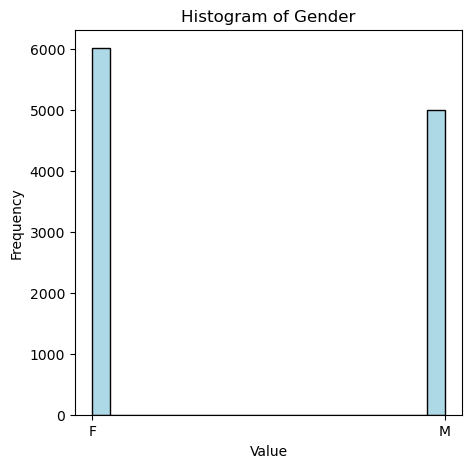

In [36]:
# Create a histogram plot for Gender Count
plt.figure(figsize=(5,5))
plt.hist(data['Gender'], bins=20, color='lightblue', edgecolor='black')
plt.title('Histogram of Gender')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

- A majority of the patients were females. 

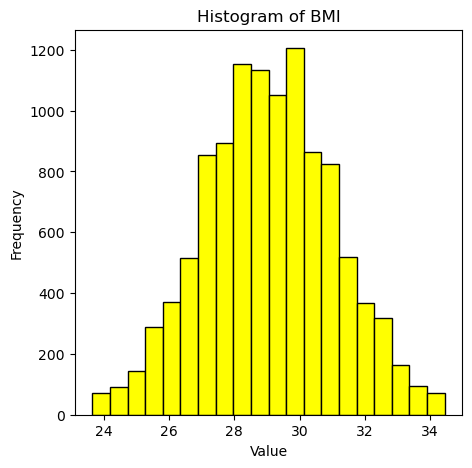

In [37]:
# Create a histogram for Body Mass Index Column
plt.figure(figsize=(5,5))
plt.hist(data['BMI'], bins=20, color='yellow', edgecolor='black')
plt.title('Histogram of BMI')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

- After imputing the outliers in the data pre-processing section, the distribution follows a bell-shaped curve which indicates normality in our dataset. 
- There is no more skewness in the data. 
- The BMI levels of patients fall under the normal range. 

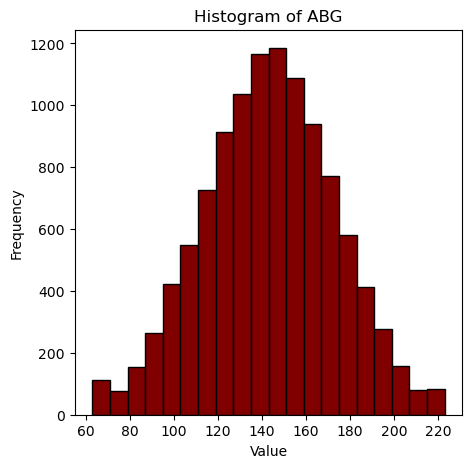

In [38]:
# Create a histogram for Body Mass Index Column
plt.figure(figsize=(5,5))
plt.hist(data['ABG'], bins=20, color='maroon', edgecolor='black')
plt.title('Histogram of ABG')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

- After imputing the outliers in the data pre-processing section, the distribution follows a bell-shaped curve which indicates normality in our dataset. 
- There is no more skewness in the data. 
- The ABG levels of patients fall under the normal range. 

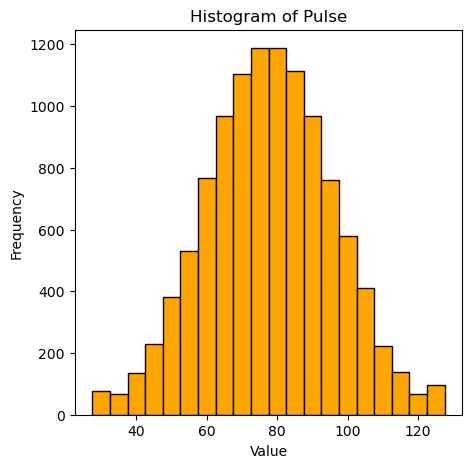

In [39]:
# Create a histogram for Pulse Column
plt.figure(figsize=(5,5))
plt.hist(data['Pulse'], bins=20, color='orange', edgecolor='black')
plt.title('Histogram of Pulse')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

- After imputing the outliers in the data pre-processing section, the distribution follows a bell-shaped curve which indicates normality in our dataset. 
- There is no more skewness in the data. 
- The Pulse of patients fall under the normal range. 

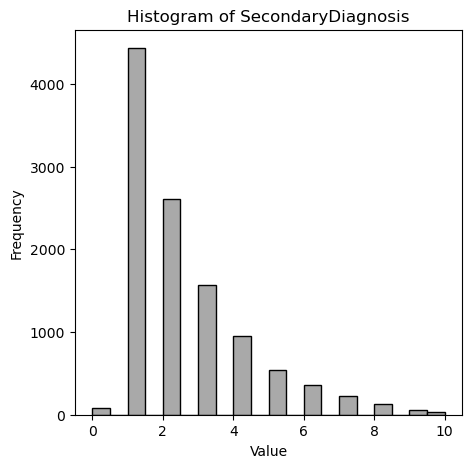

In [40]:
# Create a histogram for SecondaryDiagnosis Column
plt.figure(figsize=(5,5))
plt.hist(data['SecondaryDiagnosis'], bins=20, color='darkgrey', edgecolor='black')
plt.title('Histogram of SecondaryDiagnosis')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

- A majority of the patients had an additional diagnosis for the symptoms they showed. 
- There were very few patients that 10 Secondary Diagnosis.
- A percentage of patients that did not require a Secondary Diagnosis were very less.

##### Bivariate Analysis

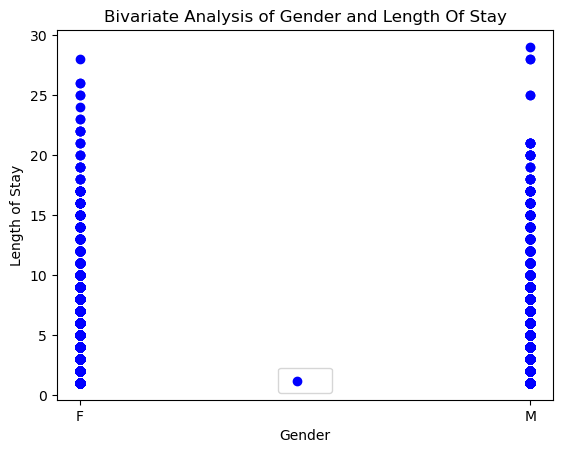

In [41]:
# Scatter plot for Gender Vs LengthofStay
plt.scatter(data['Gender'], data['LengthOfStay'], color='blue', label=' ')
plt.title('Bivariate Analysis of Gender and Length Of Stay')
plt.xlabel('Gender')
plt.ylabel('Length of Stay')
plt.legend()
plt.show()

- Most of the males had a shorter length of stay when compared to the females. 

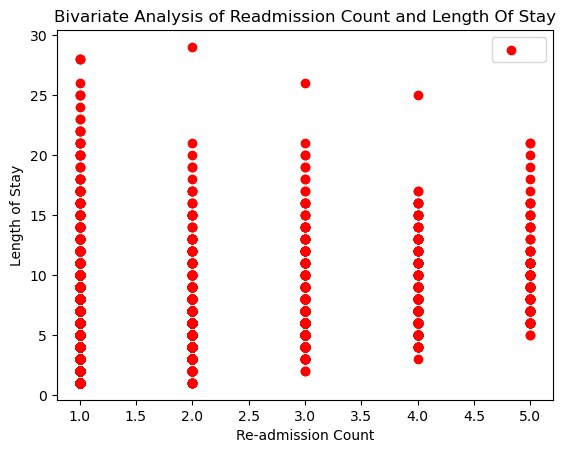

In [42]:
# Scatter plot for ReadmissionCount Vs LengthofStay
plt.scatter(data['ReadmissionCount'], data['LengthOfStay'], color='red', label=' ')
plt.title('Bivariate Analysis of Readmission Count and Length Of Stay')
plt.xlabel('Re-admission Count')
plt.ylabel('Length of Stay')
plt.legend()
plt.show()

- Patients who got readmitted twice in the hospital, stayed longer than the patients who got readmitted more than that.

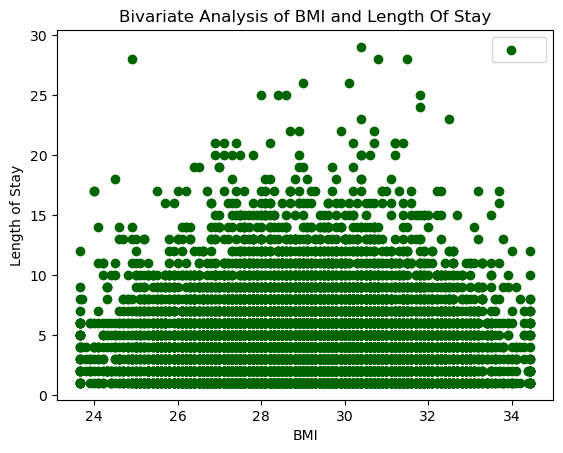

In [43]:
# Scatter plot for BMI Vs LengthofStay
plt.scatter(data['BMI'], data['LengthOfStay'], color='darkgreen', label=' ')
plt.title('Bivariate Analysis of BMI and Length Of Stay')
plt.xlabel('BMI')
plt.ylabel('Length of Stay')
plt.legend()
plt.show()

- There were a few patients with a normal BMI but a higher length of stay. 
- No correlation can be seen between BMI and Length of Stay. 

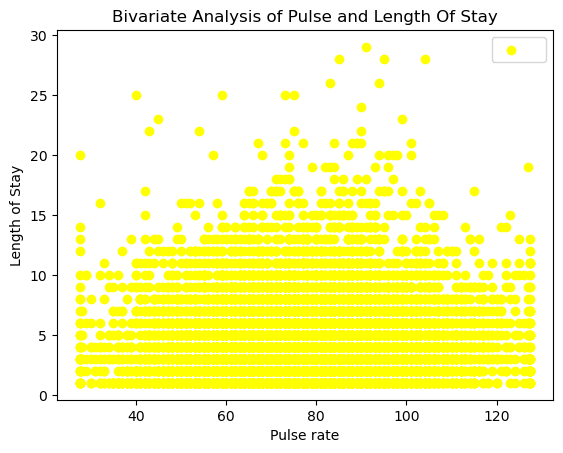

In [44]:
# Scatter plot for Pulse Vs LengthofStay
plt.scatter(data['Pulse'], data['LengthOfStay'], color='yellow', label=' ')
plt.title('Bivariate Analysis of Pulse and Length Of Stay')
plt.xlabel('Pulse rate')
plt.ylabel('Length of Stay')
plt.legend()
plt.show()

- There is no correlation between Pulse rate and Length of Stay. 

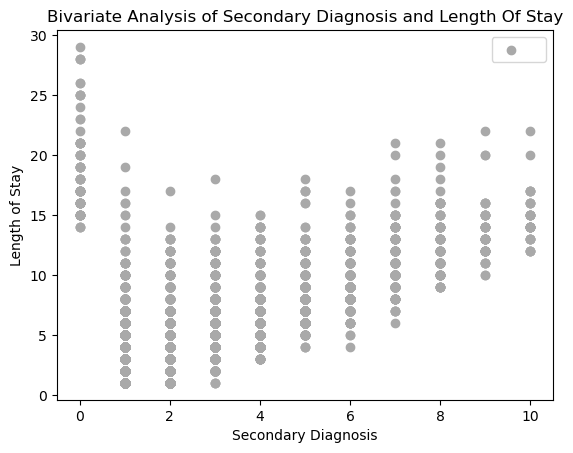

In [45]:
# Scatter plot for SecondaryDiagnosis Vs LengthofStay
plt.scatter(data['SecondaryDiagnosis'], data['LengthOfStay'], color='darkgrey', label=' ')
plt.title('Bivariate Analysis of Secondary Diagnosis and Length Of Stay')
plt.xlabel('Secondary Diagnosis')
plt.ylabel('Length of Stay')
plt.legend()
plt.show()

- Patients with no secondary diagnosis have generally a higher length of stay. 
- A trend can be seen in this analysis. As the number of secondary diagnosis, the length of stay also increases. 

### Correlation Analysis

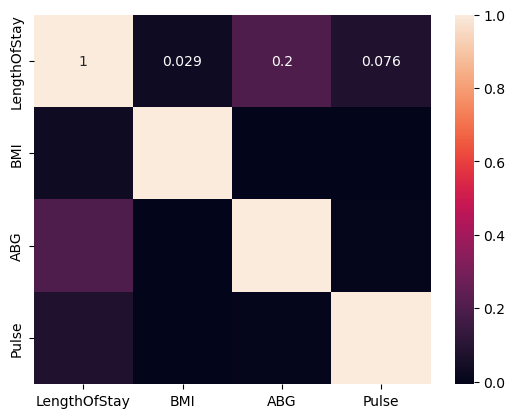

In [46]:
sns.heatmap(data.select_dtypes(include = 'number').corr(),annot = True)
plt.show()

- There is no multicollinearity since there is no figure than 0.5
- Length of stay is more strongly correlated with Readmission count and Secondary Diagnosis as compared to the other features.
- There are some features that are very strongly correlated to the target variable. 

In [47]:
data.select_dtypes(include='object').columns.tolist()

['ReadmissionCount',
 'Gender',
 'PyschologicalAilments',
 'SubstanceAbuseHistory',
 'SecondaryDiagnosis']

### Modelling

In [48]:
data_enc = pd.get_dummies(data,columns=data.select_dtypes(include='object').columns.tolist()) # Data Encoding

target_column = 'LengthOfStay'

X = data_enc.drop(['LengthOfStay'],axis=1) # Independant Features
y = data_enc['LengthOfStay'] # Tagert Variable

# Input data is split into Training and Testing data - based on random_state=1000 (Optimal value identified through Trail & Error)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)


In [49]:
# Scaling is done after train test split to prevent data leakage
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# Train the linear regression model and fitting to data
model1 = LinearRegression()
model1.fit(X_train_sc, y_train)

y_pred_train = model1.predict(X_train_sc)     # Predicting using train data set 
y_pred_test = model1.predict(X_test_sc)       # Predicting using test data set 

In [50]:
print(f'MSE of model on training data: {mean_squared_error(y_train, y_pred_train)}')
print(f"Coefficient of Determination (R Squared) on training data: {r2_score(y_train, y_pred_train)}")
print()
print(f'MSE of model on testing data: {mean_squared_error(y_test, y_pred_test)}')
print(f"Coefficient of Determination (R Squared) on testing data: {r2_score(y_test, y_pred_test)}")
print()
print()
print(f'Coefficients: {model1.coef_}')
print()
print(f'Intercepts: {model1.intercept_}')

MSE of model on training data: 1.821727012673724
Coefficient of Determination (R Squared) on training data: 0.8342532836279534

MSE of model on testing data: 1.6487345450988198
Coefficient of Determination (R Squared) on testing data: 0.8442531074473963


Coefficients: [ 9.12341861e-02  7.07125816e-01  2.28453173e-01 -4.43322055e+12
 -3.43190437e+12 -2.57792720e+12 -1.87813287e+12 -1.36755478e+12
  1.21291651e+12  1.21291651e+12  1.17005978e+13  1.17005978e+13
  2.31618888e+13  7.17948734e+11  2.31538090e+13  1.70293044e+12
  9.54690505e+12  8.28508219e+12  6.76165019e+12  5.44320777e+12
  4.20640577e+12  3.47174181e+12  2.69983753e+12  2.10165640e+12
  1.38713943e+12  1.09525250e+12]

Intercepts: 4.55141033768448


In [51]:
print('Coefficients of each features are:\n')
for i,col in enumerate(X_train.columns.tolist()):
    print(col,model1.coef_[i],sep='\t->\t')

Coefficients of each features are:

BMI	->	0.09123418607416288
ABG	->	0.7071258164126922
Pulse	->	0.2284531732685885
ReadmissionCount_1.0	->	-4433220551650.441
ReadmissionCount_2.0	->	-3431904368016.5483
ReadmissionCount_3.0	->	-2577927199891.437
ReadmissionCount_4.0	->	-1878132869822.452
ReadmissionCount_5.0	->	-1367554779706.7947
Gender_F	->	1212916511272.9216
Gender_M	->	1212916511273.3066
PyschologicalAilments_False	->	11700597826092.787
PyschologicalAilments_True	->	11700597826092.797
SubstanceAbuseHistory_No	->	23161888841915.02
SubstanceAbuseHistory_Unknown	->	717948733551.912
SubstanceAbuseHistory_Yes	->	23153809009577.215
SecondaryDiagnosis_0.0	->	1702930435358.4822
SecondaryDiagnosis_1.0	->	9546905053557.746
SecondaryDiagnosis_2.0	->	8285082186444.115
SecondaryDiagnosis_3.0	->	6761650194426.452
SecondaryDiagnosis_4.0	->	5443207766550.251
SecondaryDiagnosis_5.0	->	4206405770679.3047
SecondaryDiagnosis_6.0	->	3471741810077.5513
SecondaryDiagnosis_7.0	->	2699837528098.111
Second

In [52]:
# data.drop(['ReadmissionCount'],axis=1,inplace = True)
data.drop(['PyschologicalAilments', 'SubstanceAbuseHistory'],axis=1,inplace = True)    # Dropping these as there coefficients was low in the base model 


In [53]:
# data.drop(['Gender'],axis=1,inplace = True)    # Dropping these as there coefficients was low in the base model 
data_enc = pd.get_dummies(data,columns = data.select_dtypes(include='object').columns.tolist())    # Encoding

target_column = 'LengthOfStay'
X = data_enc.drop(['LengthOfStay'],axis = 1)              # independent features
y = data_enc['LengthOfStay']                          # dependent variable

# Input data is split into Training and Testing data - based on random_state=1000 (Optimal value identified through Trail & Error)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000) 

In [54]:
# Scaling is done after train test split to prevent data leakage
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# Train the linear regression model and fitting to data
model3 = LinearRegression()
model3.fit(X_train_sc, y_train)

y_pred_train = model3.predict(X_train_sc)     # Predicting using train data set 
y_pred_test = model3.predict(X_test_sc)       # Predicting using test data set 

print(f'MSE of model on training data: {mean_squared_error(y_train, y_pred_train)}')
print(f"Coefficient of Determination (R Squared) on training data: {r2_score(y_train, y_pred_train)}")
print()
print(f'MSE of model on testing data: {mean_squared_error(y_test, y_pred_test)}')
print(f"Coefficient of Determination (R Squared) on testing data: {r2_score(y_test, y_pred_test)}")

MSE of model on training data: 1.821619139632752
Coefficient of Determination (R Squared) on training data: 0.8342630982720806

MSE of model on testing data: 1.6514604231238392
Coefficient of Determination (R Squared) on testing data: 0.8439956087292818


In [55]:
print('Coefficients of each features are:\n')
for i,col in enumerate(X_train.columns.tolist()):
    print(col,model3.coef_[i],sep='\t->\t')

Coefficients of each features are:

BMI	->	0.09144807655239713
ABG	->	0.7005447302079185
Pulse	->	0.22223007052370833
ReadmissionCount_1.0	->	-0.6212819538556186
ReadmissionCount_2.0	->	0.07806396840741289
ReadmissionCount_3.0	->	0.3446437969652616
ReadmissionCount_4.0	->	0.4820160568312383
ReadmissionCount_5.0	->	0.5064623689883174
Gender_F	->	-0.1921387210904626
Gender_M	->	0.1921387210904632
SecondaryDiagnosis_0.0	->	1.197620148238227
SecondaryDiagnosis_1.0	->	-1.153114561741687
SecondaryDiagnosis_2.0	->	-0.5049644220502625
SecondaryDiagnosis_3.0	->	0.06979863116487599
SecondaryDiagnosis_4.0	->	0.41990248847562717
SecondaryDiagnosis_5.0	->	0.6233986952851418
SecondaryDiagnosis_6.0	->	0.7491842640981936
SecondaryDiagnosis_7.0	->	0.784261999797737
SecondaryDiagnosis_8.0	->	0.757175505032298
SecondaryDiagnosis_9.0	->	0.6182525803518023
SecondaryDiagnosis_10.0	->	0.5530827855347693


Even though, the model accuracy dropped. The coefficient weightages are making more sense now. 

#### Conclusion:
After handling the outliers, removing features and changing data type the model r squared values has increased for both the training and testing dataset. The training and the testing accuracy is both around 83%. This tells us that the model is neither overfitting nor undefitting. This is a good model for this data as 83% of the variance in the target variable is explained by the independent features.

From our further analysis of the coefficients of the equation, we can see that current health condition as well as patient history is very important in predicting the length of stay. 

Gender, Psychological Condition or Substance Abuse history are not relevant to our analysis.

<h1><center>END</center></h1>